# **Plant Seedling Classification**



### **Context:**
In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

### **Objective:**

Building a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

### **Data Description:**

This dataset contains images of unique plants belonging to 12 different species.
- The data file names are:
 -  images.npy
 - Label.csv

- Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Plant Species**
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet









In [1]:
# Mount Google drive to access the dataset (monkeys_dataset.zip)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [2]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping                                              # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## **Reading the dataset**

In [4]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Files/Data/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Files/Data/Labels.csv')

In [5]:
# Checking the labels

labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [6]:
# Checking labels' unique values

np.unique(labels)

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

## **Overview of the dataset**


Shape of the images and labels

In [7]:
print("The shape of the image is: ", images.shape)

print("The shape of the labels is: ", labels.shape)

The shape of the image is:  (4750, 128, 128, 3)
The shape of the labels is:  (4750, 1)


There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Plotting images using OpenCV and matplotlib

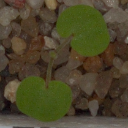

In [8]:
# Use openCV to show an image

cv2_imshow(images[4])

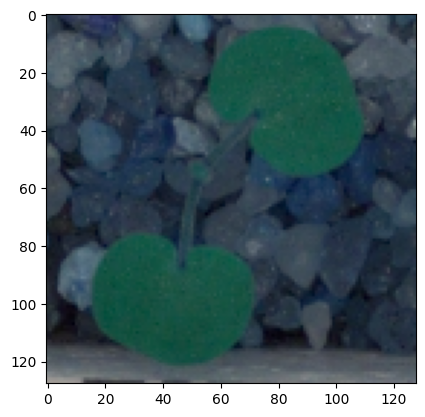

In [9]:
# Use Matplotlib to show the same image


plt.imshow(images[4])

In [10]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## **Exploratory Data Analysis**

In [11]:
# Checking unique plant seeds in the data

labels['Label'].nunique()

12

In [12]:
labels['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

In [13]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaining the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

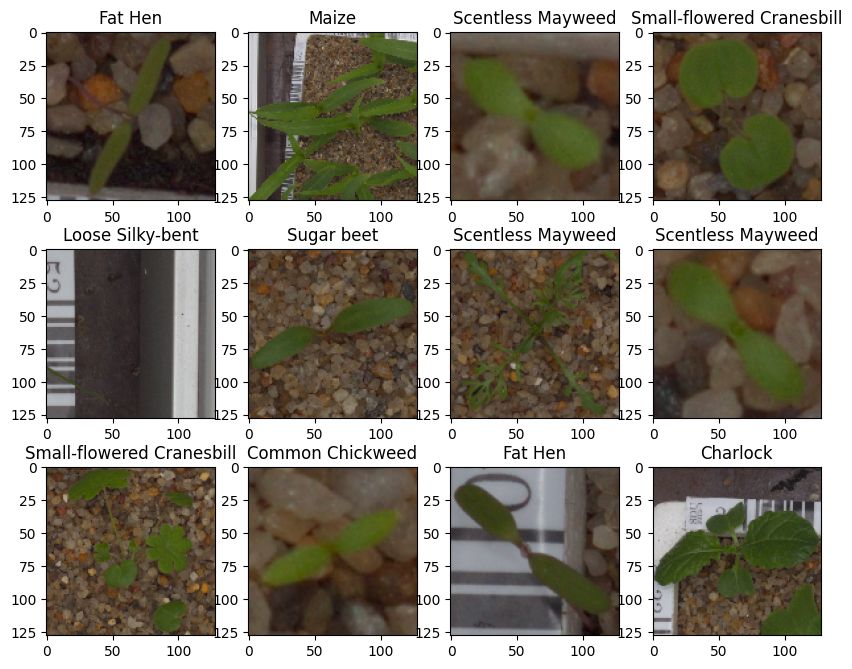

In [19]:
plot_images(images,labels)

<b> Checking for data imbalance

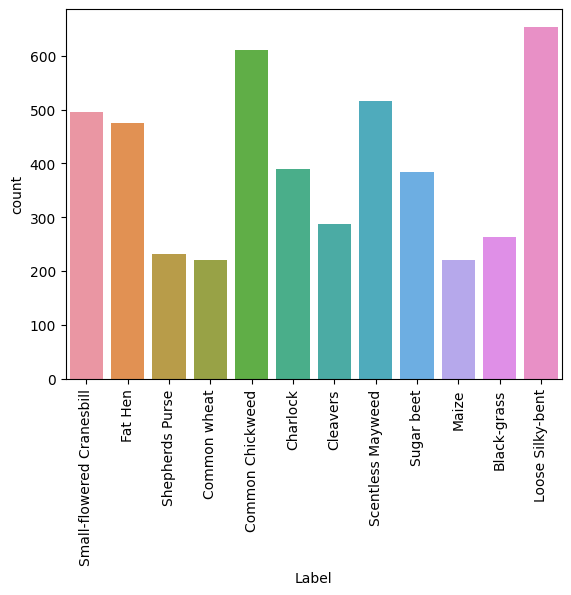

In [14]:
 sns.countplot(x ='Label', data = labels)
 plt.xticks(rotation=90);

- From the above plot, the dataset is obviously imbalanced.


### Resizing images
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [15]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

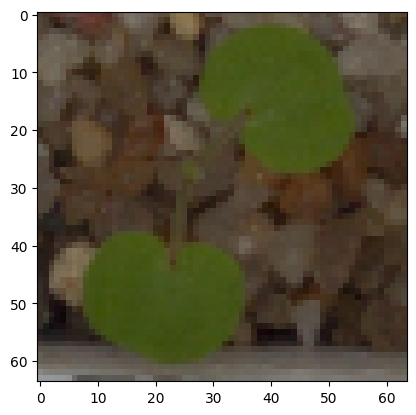

In [16]:
# show one image
plt.imshow(images_decreased[4]);

## Visualizing images using Gaussian Blur

In [17]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


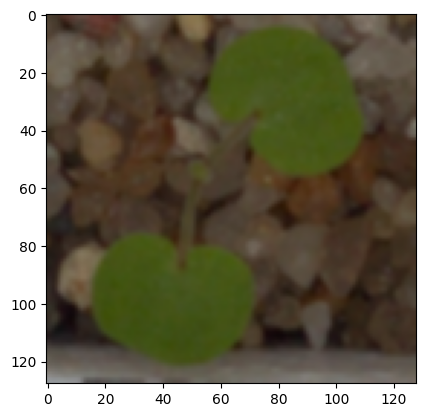

In [18]:
plt.imshow(images_gb[4]);

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

## **Splitting the dataset**

- Using the train_test_split() function from scikit-learn, the dataset will be split into train set(80%), test set(10%), and validation set(10%).


In [19]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [20]:
print("Train set shape is: ", X_train.shape,y_train.shape)
print("Validation set shape is: ", X_val.shape,y_val.shape)
print("Test set shape is: ", X_test.shape,y_test.shape)

Train set shape is:  (3847, 64, 64, 3) (3847, 1)
Validation set shape is:  (428, 64, 64, 3) (428, 1)
Test set shape is:  (475, 64, 64, 3) (475, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


## Encoding the target labels

In [21]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

## Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [22]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## **Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

In [23]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [24]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [37]:
# Creating an instance of the first sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), padding = 'same', activation = "relu", input_shape = (64, 64, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# Adding second conv layer with 64 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(64, (3, 3), padding = 'same', activation = "relu"))
# Adding max pooling to reduce the size of output of second conv layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons  and Dropout of 0.3
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation = "softmax"))

# Using Adam Optimizer
adam = Adam()

# Compile model
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# Generating the summary of the model
model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

In [38]:
# define early stopping layer


model_filename = "/content/drive/MyDrive/Files/Data/plant_seed.hdf5"
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt = ModelCheckpoint(model_filename, verbose = 1, save_best_only = True)
callbacks_list = [chkpt, es]

### <b> Fitting the model on the train data

In [39]:
his_1 = model.fit(X_train_normalized, y_train_encoded, batch_size = 32,
                  epochs = 25, callbacks = callbacks_list, verbose = 2,
                  validation_data = (X_val_normalized,y_val_encoded))

Epoch 1/25

Epoch 1: val_loss improved from inf to 3.93012, saving model to /content/drive/MyDrive/Files/Data/plant_seed.hdf5
121/121 - 14s - loss: 2.2258 - accuracy: 0.2740 - val_loss: 3.9301 - val_accuracy: 0.0467 - 14s/epoch - 119ms/step
Epoch 2/25

Epoch 2: val_loss did not improve from 3.93012
121/121 - 1s - loss: 1.7995 - accuracy: 0.3738 - val_loss: 6.0058 - val_accuracy: 0.1028 - 936ms/epoch - 8ms/step
Epoch 3/25

Epoch 3: val_loss did not improve from 3.93012
121/121 - 1s - loss: 1.5680 - accuracy: 0.4310 - val_loss: 9.0938 - val_accuracy: 0.0911 - 850ms/epoch - 7ms/step
Epoch 4/25

Epoch 4: val_loss did not improve from 3.93012
121/121 - 1s - loss: 1.3973 - accuracy: 0.4900 - val_loss: 5.0945 - val_accuracy: 0.1706 - 831ms/epoch - 7ms/step
Epoch 4: early stopping


### **Model Evaluation**

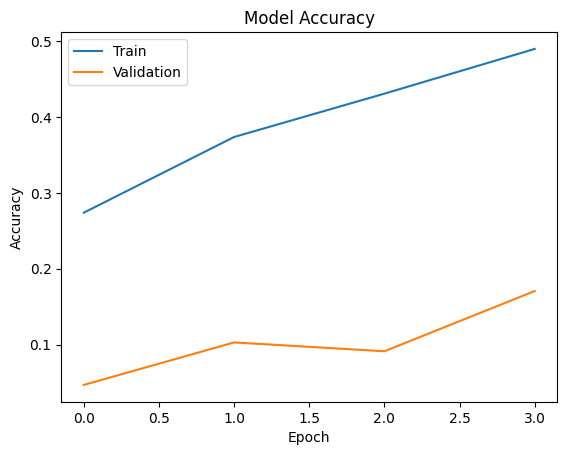

In [40]:
 plt.plot(his_1.history['accuracy'])
 plt.plot(his_1.history['val_accuracy'])
 plt.title('Model Accuracy')
 plt.ylabel('Accuracy')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was not good just as the validation accuracy was not good.**
*   The model seems to underfit on the data.
*   Since the model did not learn anything and underfits, there is no point evaluating or checking the confusion matrix hence we will proceed to improving our model2 with data augmentation.






### **Evaluating the model on test data**

In [63]:
 accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 5.0946 - accuracy: 0.1789 - 333ms/epoch - 22ms/step


### **Generating the predictions using test data**

In [65]:
 #Here we would get the output as probablities for each category
 y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





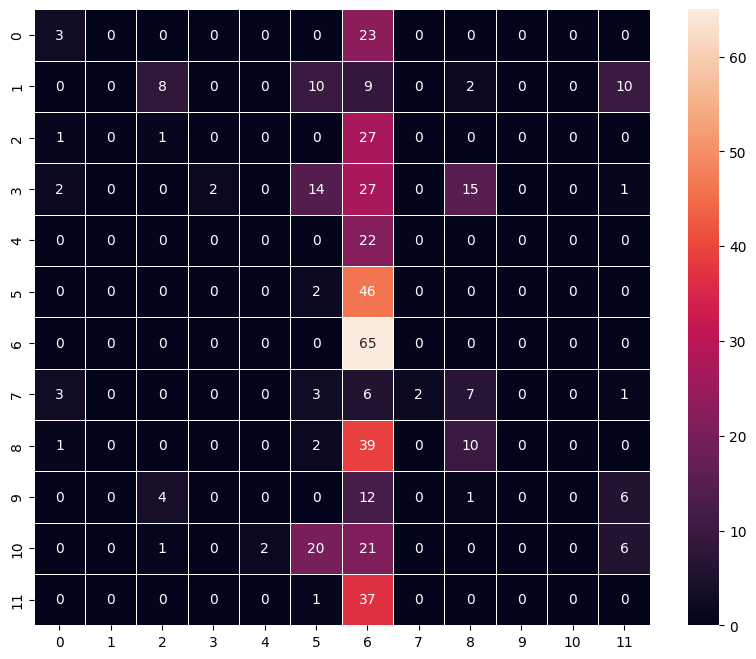

In [66]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 0,3, and 4 are well classified.
- We can also observe that classes 1,2,5,7 and 9 are mostly misclassified.

# Model-2

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

## **Data Augmentation**



In [41]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [42]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range = 0.2,
                              zoom_range = 0.2
                              )
#test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [43]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
adam=Adam()
# Compile model
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

In [44]:
model2_filename = "/content/drive/MyDrive/Files/Data/plant_seed2.hdf5"
#es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt2 = ModelCheckpoint(model2_filename, verbose = 1, save_best_only = True)
callbacks_list2 = [chkpt2, es]

In [45]:
# Epochs
epochs = 25
# Batch size
batch_size = 32

his_2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks = callbacks_list2)

Epoch 1/25
120/120 [==============================] - ETA: 0s - loss: 2.1174 - accuracy: 0.3153
Epoch 1: val_loss improved from inf to 3.47061, saving model to /content/drive/MyDrive/Files/Data/plant_seed2.hdf5
120/120 [==============================] - 7s 41ms/step - loss: 2.1174 - accuracy: 0.3153 - val_loss: 3.4706 - val_accuracy: 0.0467
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 1.6745 - accuracy: 0.4312
Epoch 2: val_loss did not improve from 3.47061
120/120 [==============================] - 5s 39ms/step - loss: 1.6745 - accuracy: 0.4312 - val_loss: 4.6177 - val_accuracy: 0.0561
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 1.4808 - accuracy: 0.4910
Epoch 3: val_loss did not improve from 3.47061
120/120 [==============================] - 5s 43ms/step - loss: 1.4808 - accuracy: 0.4910 - val_loss: 5.5347 - val_accuracy: 0.1262
Epoch 4/25
120/120 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.5232
Epoch 4: va

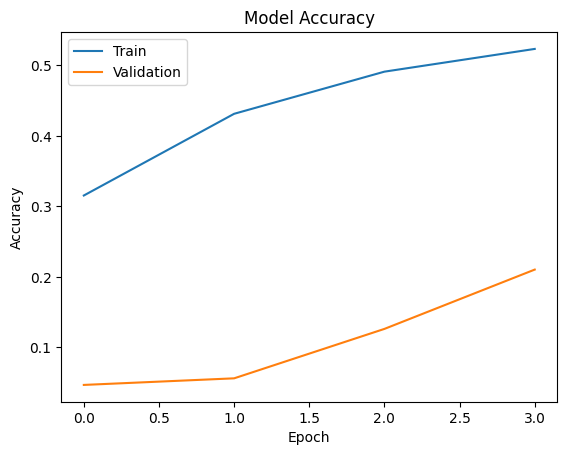

In [47]:
plt.plot(his_2.history['accuracy'])
plt.plot(his_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 3.4425 - accuracy: 0.2084 - 291ms/epoch - 19ms/step


We can observe from the plot and evaluation that our model  has improved compared to our previous model but overfits and still not good enough.

In [67]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


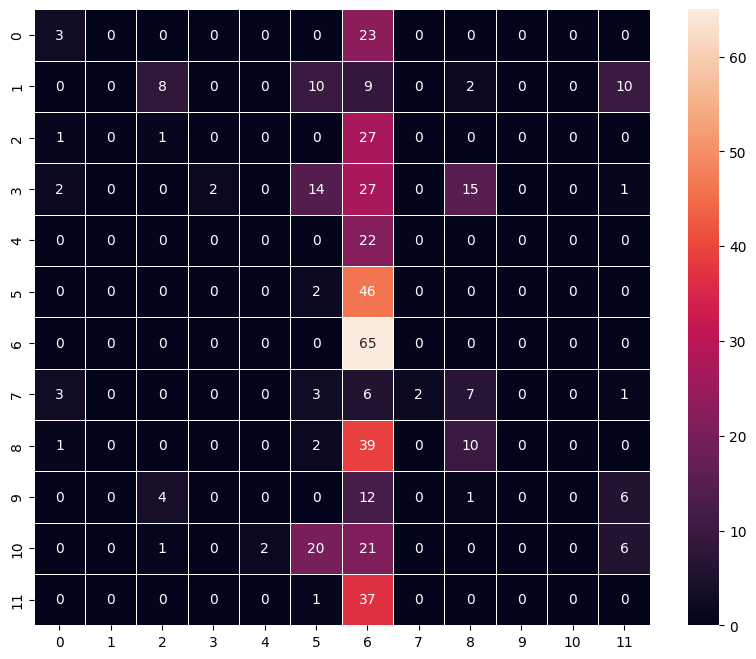

In [68]:
# # Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

# Transfer Learning using VGG16

In [50]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [51]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [55]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.3))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                131136    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 12)                396       
                                                                 
Total params: 14,848,300
Trainable params: 133,612
Non

In [56]:
model3_filename = "/content/drive/MyDrive/Files/Data/plant_seed3.hdf5"
#es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt3 = ModelCheckpoint(model3_filename, verbose = 1, save_best_only = True)
callbacks_list3 = [chkpt3, es]

In [57]:
# Epochs
epochs = 10
# Batch size
batch_size = 32

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks = callbacks_list3)

Epoch 1/10
120/120 [==============================] - ETA: 0s - loss: 2.2785 - accuracy: 0.2191
Epoch 1: val_loss improved from inf to 2.02059, saving model to /content/drive/MyDrive/Files/Data/plant_seed3.hdf5
120/120 [==============================] - 9s 63ms/step - loss: 2.2785 - accuracy: 0.2191 - val_loss: 2.0206 - val_accuracy: 0.3061
Epoch 2/10
120/120 [==============================] - ETA: 0s - loss: 1.9331 - accuracy: 0.3326
Epoch 2: val_loss improved from 2.02059 to 1.77773, saving model to /content/drive/MyDrive/Files/Data/plant_seed3.hdf5
120/120 [==============================] - 5s 43ms/step - loss: 1.9331 - accuracy: 0.3326 - val_loss: 1.7777 - val_accuracy: 0.3762
Epoch 3/10
120/120 [==============================] - ETA: 0s - loss: 1.7413 - accuracy: 0.3913
Epoch 3: val_loss improved from 1.77773 to 1.65444, saving model to /content/drive/MyDrive/Files/Data/plant_seed3.hdf5
120/120 [==============================] - 5s 45ms/step - loss: 1.7413 - accuracy: 0.3913 - val

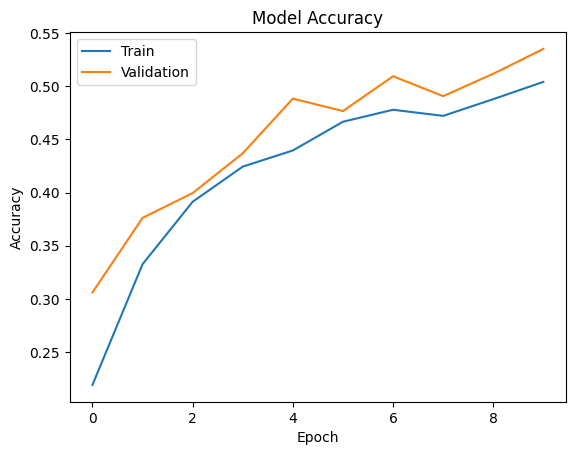

In [58]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.2963 - accuracy: 0.5263 - 796ms/epoch - 53ms/step


In [60]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

15/15 [==============================] - 0s 16ms/step


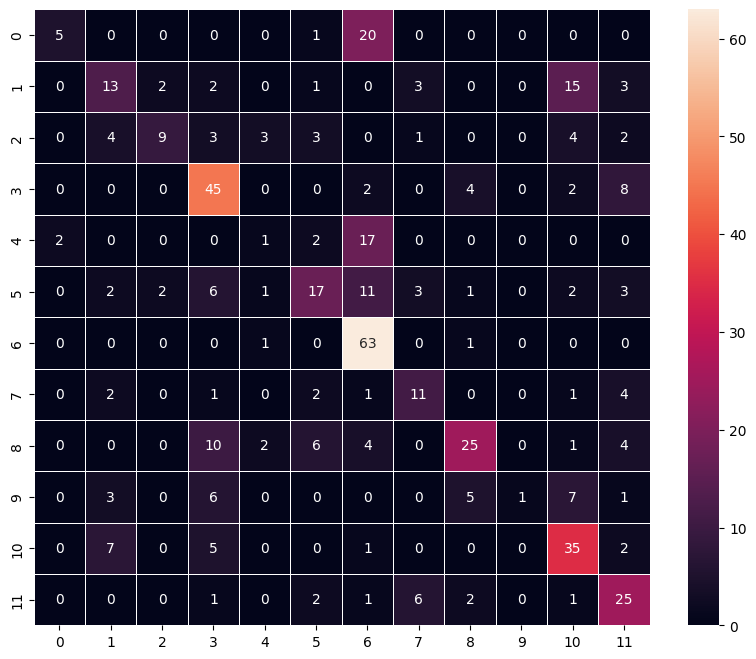

In [61]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- According to the confusion matrix and accuracy curve, the VGG16 model learned very well and generalizes appreciably compared to the Model-2, hence the VGG16 model would be our best model to be used to predict and visualize our test images.


## **Visualizing the prediction:**

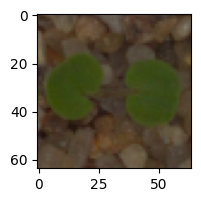

1/1 [==============================] - 0s 390ms/step
Predicted Label ['Common Chickweed']
True Label Small-flowered Cranesbill


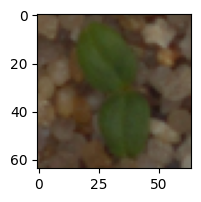

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Fat Hen']
True Label Cleavers


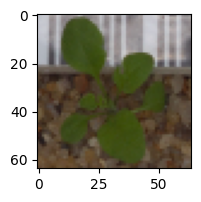

1/1 [==============================] - 0s 34ms/step
Predicted Label ['Charlock']
True Label Shepherds Purse


In [62]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Conclusion
- From the confusion matrix and accuracy curve of all the models trained, VGG16 model learned most and turned out to be the best model however all its predictions were wrong.
- The test accuracy of the VGG16 model is 52%.
- Data Augmentation has also helped in improving the model.
- No doubt, simply employing the transfer learning model can produce a better outcome than any ordinary CNN, however, I need to tune more parameters to improve on my model.

In [69]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['49%','52%','50%'],'Validation Accuracy':['17%','21%','54%'],'Test Accuracy':['18%','21%','52%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,49%,17%,18%
1,CNN Model with Data Augmentation,52%,21%,21%
2,Transfer Learning Model,50%,54%,52%


## Scope of Improvement

The deadline for submission did not afford me the time to further improve the models. However, these models can be improved with the following approaches:

  - Use of different convolution blocks and different numbers of filters.
  - Use of different neurons.
  - Use of different optimizers.
  - Use of different learning rates.
  - Use of different batch size.
  - Use of the original image size.
